In [1]:
from imagem import Imagem
from glob import glob
import Functions as fc
import numpy as np
from skimage.io import imread,imshow,imsave,imread_collection
import cv2
from skimage.exposure import equalize_hist
from skimage.filters import median
from IPython.display import clear_output
from tqdm import tqdm
import seaborn as sns
import time
from sklearn.decomposition import PCA
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

In [2]:
originais = sorted(glob(f'./imagens/*/*', recursive=True))

imgs = {
    'daisy': sorted(glob(f'./imagens/daisy/*', recursive=True)),
    'dandelion': sorted(glob(f'./imagens/dandelion/*', recursive=True)),
    'rose': sorted(glob(f'./imagens/rose/*', recursive=True)),
    'sunflower': sorted(glob(f'./imagens/sunflower/*', recursive=True)),
    'tulip': sorted(glob(f'./imagens/tulip/*', recursive=True))
}

In [3]:
def poeInt(imagem):
    linhas, colunas = imagem.shape
    copy = np.zeros((linhas, colunas), dtype=np.uint8)
    for l in range(linhas):
        for c in range(colunas):
                if imagem[l][c] == True:
                    copy[l][c] = 255
    return copy

In [4]:
def lerTodos(originais):
    imgs = []
    for i in tqdm(originais, desc='Imagens:  '):
        img = Imagem(i)
        img.ler()
        img.filtros['eq'] = img.equalize()
        img.filtros['median'] = median(img.filtros['eq'] )
        #img.filtros['otsu'] = fc.aplicaOtsu(img.filtros['median'])
        imgs.append(img)
    
    
    return imgs

In [5]:
def subtraiCamada(img, camada='b'):
    img0 = img.filtros['median'].copy()
    img0 = img0/255
    img0 = img0[:,:,0] + img0[:,:,1] + img0[:,:,2]

    img1 = img.filtros['otsu'][camada].copy()
    img1 = img1/255

    img0[~img1.astype(bool)] = 0
    
    return img0

In [6]:
def subtrai(imgs):
    for i in tqdm(imgs, desc='Otsu:  '):
        i.filtros['otsu'] = {
            'r': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,0])),
            'g': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,1])),
            'b': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,2]))
        }

        i.filtros['inteiro'] = i.inteiro()

        i.filtros['normalize'] = i.normalize()

        """ img0 = i.filtros['median'].copy()
        img0 = img0/255
        img0 = img0[:,:,0] + img0[:,:,1] + img0[:,:,2]


        img1 = i.filtros['otsu']['b'].copy()
        img1 = img1/255

        img0[~img1.astype(bool)] = 0 """

        i.filtros['sub'] = {
            'r': subtraiCamada(i, 'r'),
            'g': subtraiCamada(i, 'g'),
            'b': subtraiCamada(i, 'b')
        }

        """ 
            Fazer a subtração dos canais de cor com o otsu.
            
        """

        """ i.filtros['otsu']['rgb'] = {
            'red': cv2.merge(
                (
                    i.filtros['otsu']['r'],
                    i.filtros['inteiro'][:,:,1],
                    i.filtros['inteiro'][:,:,2]
                )
            ),
            'green': cv2.merge(
                (
                    i.filtros['inteiro'][:,:,0],
                    i.filtros['otsu']['g'],
                    i.filtros['inteiro'][:,:,2]
                )
            ),
            'blue': cv2.merge(
                (
                    i.filtros['inteiro'][:,:,0],
                    i.filtros['inteiro'][:,:,1],
                    i.filtros['otsu']['b']
                )
            )
        } """
    
    return imgs


In [7]:
imagens = lerTodos(originais)

Imagens:  : 100%|██████████| 500/500 [00:42<00:00, 11.72it/s]


In [8]:
imagens = subtrai(imagens)

Otsu:  : 100%|██████████| 500/500 [01:20<00:00,  6.23it/s]


/home/matheus/.local/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


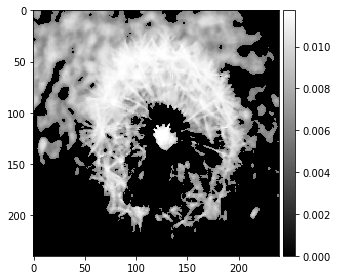

In [9]:
imshow(imagens[100].filtros['sub']['g'], cmap='gray')

In [17]:
""" red = {
    'daisy': [ imagens[x].filtros['sub']['r'] for x in range(100) ],
    'dandelion': [ imagens[x].filtros['sub']['r'] for x in range(100,200) ],
    'rose': [ imagens[x].filtros['sub']['r'] for x in range(200,300) ],
    'sunflower': [ imagens[x].filtros['sub']['r'] for x in range(300,400) ],
    'tulip': [ imagens[x].filtros['sub']['r'] for x in range(400,500) ]
}

green = {
    'daisy': [ imagens[x].filtros['sub']['g'] for x in range(100) ],
    'dandelion': [ imagens[x].filtros['sub']['g'] for x in range(100,200) ],
    'rose': [ imagens[x].filtros['sub']['g'] for x in range(200,300) ],
    'sunflower': [ imagens[x].filtros['sub']['g'] for x in range(300,400) ],
    'tulip': [ imagens[x].filtros['sub']['g'] for x in range(400,500) ]
}

blue = {
    'daisy': [ imagens[x].filtros['sub']['b'] for x in range(100) ],
    'dandelion': [ imagens[x].filtros['sub']['b'] for x in range(100,200) ],
    'rose': [ imagens[x].filtros['sub']['b'] for x in range(200,300) ],
    'sunflower': [ imagens[x].filtros['sub']['b'] for x in range(300,400) ],
    'tulip': [ imagens[x].filtros['sub']['b'] for x in range(400,500) ]
} """

In [10]:
auxR = [ imagens[x].filtros['sub']['b'] for x in range(len(imagens)) ]

In [11]:
auxG = [ imagens[x].filtros['sub']['g'] for x in range(len(imagens)) ]

auxB = [ imagens[x].filtros['sub']['r'] for x in range(len(imagens)) ]

In [12]:
imagens[0].salvar(auxR, originais, caminho='./subs/red')
imagens[0].salvar(auxG, originais, caminho='./subs/green')
imagens[0].salvar(auxB, originais, caminho='./subs/blue')

In [13]:
red = imread_collection(sorted(glob(f'./subs/red/*/*', recursive=True)))
green = imread_collection(sorted(glob(f'./subs/green/*/*', recursive=True)))
blue = imread_collection(sorted(glob(f'./subs/blue/*/*', recursive=True)))

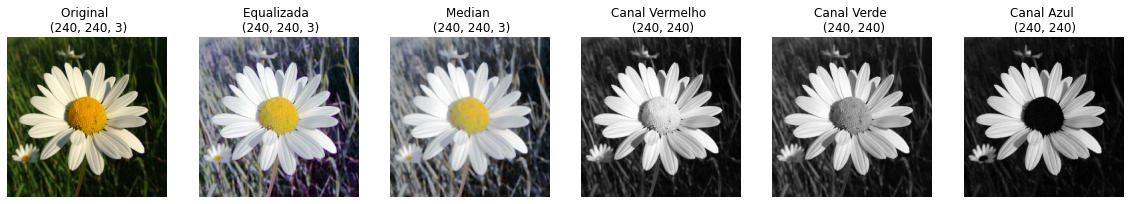

In [16]:
imagens[9].shows(5)

In [14]:
labels = []
labelsInt = []
k = 0
for j in ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']:
    for i in range(100):
        labels.append(j)
        labelsInt.append(k)
    k += 1

---
# Descritores

In [15]:
def aplicaGLCM(images, labels):
    features = np.zeros((len(labels),18)) #6 features x 3 color channels
    start = time.time()
    d = 5
    for id_im,imagem in enumerate(images):
        clear_output(wait=True)
        print('Extraindo atributos: {} imagens processadas de {}.'.format(id_im+1,len(images)))
        for id_ch in range(3):
            matrix0 = greycomatrix(imagem[:,:,id_ch], [d], [0],normed=True)
            matrix1 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/4],normed=True)
            matrix2 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/2],normed=True)
            matrix3 = greycomatrix(imagem[:,:,id_ch], [d], [3*np.pi/4],normed=True)
            matrix = (matrix0+matrix1+matrix2+matrix3)/4 
            props = np.zeros((6))
            props[0] = greycoprops(matrix,'contrast')
            props[1] = greycoprops(matrix,'dissimilarity')
            props[2] = greycoprops(matrix,'homogeneity')
            props[3] = greycoprops(matrix,'energy')
            props[4] = greycoprops(matrix,'correlation')
            props[5] = greycoprops(matrix,'ASM')
            features[id_im,id_ch*6:(id_ch+1)*6] = props

    end = time.time()
    tempo = end - start
    clear_output(wait=True)
    return features, tempo

In [ ]:
rRed, tempo = aplicaGLCM(red, labels)
rGreen, tempo = aplicaGLCM(green, labels)
rBlue, tempo = aplicaGLCM(blue, labels)

<AxesSubplot:>

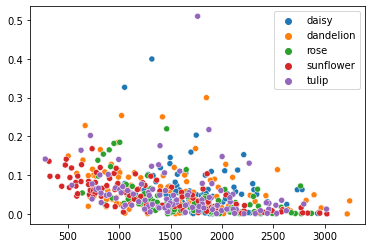

In [17]:
sns.scatterplot(x=rRed[:,0], y=rRed[:,5], hue=labels)

<AxesSubplot:>

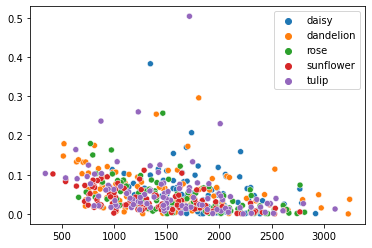

In [18]:
sns.scatterplot(x=rGreen[:,0], y=rGreen[:,5], hue=labels)

<AxesSubplot:>

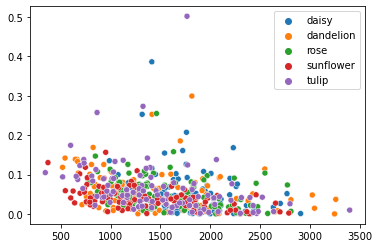

In [19]:
sns.scatterplot(x=rBlue[:,0], y=rBlue[:,5], hue=labels)

In [25]:
def aplicaPCA(features):
    pca = PCA()
    pca.fit(features)
    transform = pca.transform(features)
    print(np.sum(pca.explained_variance_ratio_[0:3]))
    return transform

In [26]:
transRed = aplicaPCA(rRed)
transGreen = aplicaPCA(rGreen)
transBlue = aplicaPCA(rBlue)

0.9999983544615109
0.9999990357781031
0.999998853121441


# Classification

- Dividir o espaço de atributos em regiões;
- A quantidade de regiões é o número de classes;
- A acurácia da classificação está diretamente liga à qualidade dos atributos.

### Train/Test

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix,accuracy_score
from sklearn.svm import SVC

In [28]:
def classificationForest(X,y, t=0.9):
    """ com random forest """
    # separar conjuntos de treino e teste
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=t,shuffle=True, random_state=42)
    # criar instancia do classificador
    clf = RandomForestClassifier()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)
    return acuracia

In [29]:
def classificationXBR(X, y, t=0.9):
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=t,shuffle=True)
    # criar instancia do classificador
    clf = xgb.XGBClassifier()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)
    return acuracia

In [30]:
rRedAc = []
for i in [0.6, 0.7, 0.8, 0.9]:
    rRedAc.append(
        {
            "Original": {
                'rf': classificationForest(rRed, labelsInt, t=i),
                'xbr': classificationXBR(rRed, labelsInt, t=i)
            },
            "Transform": {
                'rf': classificationForest(transRed, labelsInt, t=i),
                'xbr': classificationXBR(transRed, labelsInt, t=i)
            }
        }
    )

rRedAc

[{'Original': {'rf': 0.39, 'xbr': 0.455},
  'Transform': {'rf': 0.515, 'xbr': 0.505}},
 {'Original': {'rf': 0.4533333333333333, 'xbr': 0.47333333333333333},
  'Transform': {'rf': 0.5733333333333334, 'xbr': 0.58}},
 {'Original': {'rf': 0.47, 'xbr': 0.5},
  'Transform': {'rf': 0.55, 'xbr': 0.59}},
 {'Original': {'rf': 0.46, 'xbr': 0.38},
  'Transform': {'rf': 0.58, 'xbr': 0.5}}]

In [31]:
rGreenAc = []
for i in [0.6, 0.7, 0.8, 0.9]:
    rGreenAc.append(
        {
            "Original": {
                'rf': classificationForest(rGreen, labelsInt, t=i),
                'xbr': classificationXBR(rGreen, labelsInt, t=i)
            },
            "Transform": {
                'rf': classificationForest(transGreen, labelsInt, t=i),
                'xbr': classificationXBR(transGreen, labelsInt, t=i)
            }
        }
    )

rGreenAc

[{'Original': {'rf': 0.37, 'xbr': 0.37},
  'Transform': {'rf': 0.575, 'xbr': 0.49}},
 {'Original': {'rf': 0.41333333333333333, 'xbr': 0.3933333333333333},
  'Transform': {'rf': 0.5466666666666666, 'xbr': 0.5066666666666667}},
 {'Original': {'rf': 0.47, 'xbr': 0.42},
  'Transform': {'rf': 0.57, 'xbr': 0.55}},
 {'Original': {'rf': 0.48, 'xbr': 0.48},
  'Transform': {'rf': 0.62, 'xbr': 0.52}}]

In [32]:
rBlueAc = []
for i in [0.6, 0.7, 0.8, 0.9]:
    rBlueAc.append(
        {
            "Original": {
                'rf': classificationForest(rBlue, labelsInt, t=i),
                'xbr': classificationXBR(rBlue, labelsInt, t=i)
            },
            "Transform": {
                'rf': classificationForest(transBlue, labelsInt, t=i),
                'xbr': classificationXBR(transBlue, labelsInt, t=i)
            }
        }
    )

rBlueAc

[{'Original': {'rf': 0.475, 'xbr': 0.425},
  'Transform': {'rf': 0.55, 'xbr': 0.49}},
 {'Original': {'rf': 0.44, 'xbr': 0.4066666666666667},
  'Transform': {'rf': 0.5466666666666666, 'xbr': 0.5266666666666666}},
 {'Original': {'rf': 0.53, 'xbr': 0.4}, 'Transform': {'rf': 0.59, 'xbr': 0.5}},
 {'Original': {'rf': 0.52, 'xbr': 0.6}, 'Transform': {'rf': 0.68, 'xbr': 0.6}}]

# Grid Seach

In [33]:
def aplicaGS_randomForest(imgs, labels, test_size=0.20):
    #para treinar o classificador
    x_train, x_test, y_train, y_test = train_test_split(imgs,labels, test_size=test_size, random_state=42)

    #criar instancia do classificador
    clf = RandomForestClassifier()

    #definir os parametros a serem testados
    param_grid = {
        'n_estimators': [100,110,120,150,200]
    }

    #criar instancia do grid search
    grid = GridSearchCV(
        clf,
        param_grid,
        scoring = 'accuracy',
        cv = 5
        #n_jobs=-1
    )

    #treinar o classificador
    grid.fit(x_train, y_train)

    return grid.best_params_

In [34]:
def aplicaGS_xbr(imgs, labels, test_size=0.2):
    #para treinar o classificador
    x_train, x_test, y_train, y_test = train_test_split(imgs,labels, test_size=test_size, random_state=42)

    #criar instancia do classificador
    clf = xgb.XGBClassifier()



    #definir os parametros a serem testados
    param_grid = {
        'n_estimators': [100,110,120,150,200]
    }

    #criar instancia do grid search
    grid = GridSearchCV(
        clf,
        param_grid,
        scoring = 'accuracy',
        cv = 5
        #n_jobs=-1
    )

    #treinar o classificador
    grid.fit(x_train, y_train)

    return grid.best_params_

In [35]:
redParams = {
    'rf': aplicaGS_randomForest(rRed, labelsInt),
    'xbr': aplicaGS_xbr(rRed, labelsInt)
}

In [36]:
redParams

{'rf': {'n_estimators': 200}, 'xbr': {'n_estimators': 110}}

# Cross Validation

## Random Forest

In [37]:
def crossValidationRF(imgs, labels, bestPrms, test=0.3):
    # para treinar o classificador
    x_train, x_test, y_train, y_test = train_test_split(imgs,labels, test_size=test, random_state=42)
    
    # criar instancia do classificador
    clf = RandomForestClassifier(n_estimators=bestPrms['rf']['n_estimators'])
    
    # treinar o classificador
    clf.fit(x_train, y_train)

    # realizar a predicao
    pred = clf.predict(x_test)

    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)

    # Criar as métricas
    metrics = ['accuracy','precision_macro','recall_macro','f1_macro']

    # Criar o dicionário de resultados
    scores_rf = cross_validate(clf, imgs, labels, cv=5, scoring=metrics)

    # Criar o dicionário de resultados
    kappa = make_scorer(cohen_kappa_score)

    
    scores_rf_kappa = cross_validate(clf,imgs,labels,cv=5, scoring=kappa)


    clear_output(wait=True)


    return acuracia, scores_rf, scores_rf_kappa

In [38]:
acRf, scoresRf, scoresRfKappa = crossValidationRF(rRed, labelsInt, redParams)

In [39]:
acRf

0.41333333333333333

In [40]:
scoresRf

{'fit_time': array([0.30128002, 0.27404404, 0.29926276, 0.28578019, 0.29015636]),
 'score_time': array([0.01566696, 0.01882148, 0.01853943, 0.01561356, 0.01546383]),
 'test_accuracy': array([0.44, 0.44, 0.43, 0.43, 0.44]),
 'test_precision_macro': array([0.42171153, 0.44577422, 0.43723453, 0.40594203, 0.43244444]),
 'test_recall_macro': array([0.44, 0.44, 0.43, 0.43, 0.44]),
 'test_f1_macro': array([0.42878671, 0.44096516, 0.41868659, 0.41405014, 0.43436314])}

In [41]:
scoresRfKappa

{'fit_time': array([0.26941156, 0.28017163, 0.26752496, 0.26228404, 0.2685771 ]),
 'score_time': array([0.01500678, 0.01283002, 0.0127151 , 0.01553869, 0.01379633]),
 'test_score': array([0.2875, 0.25  , 0.275 , 0.2625, 0.35  ])}

In [42]:
scoresRfKappa['test_score'].mean(), scoresRfKappa['test_score'].std()

(0.285, 0.03482097069296029)